In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
from collections import deque
import copy
import ptan

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from maddpg_model import Config,Actor,Critic,ReplayBuffer

In [3]:
env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64',no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
state_size = env_info.vector_observations.shape[1]
action_size = env_info.previous_vector_actions.shape[0]

In [6]:
config = Config()

writer = SummaryWriter(comment="-tennis_maddpg")

In [7]:
class MDDPGAgent(object):
    """
        This Agent is very similar to a DDPG Agent with the only difference that the critic network leverages the full states and actions for both agents
        The Actor only uses it's own network so that pst training there is no more sharing of information between the agents.
    
    """
        
    def __init__(self, state_size, action_size, num_agents,config):
        
        self.state_size = state_size
        self.action_size = action_size        
        self.config = config
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size,config.ACTOR_FC1_UNITS,config.ACTOR_FC2_UNITS).to(config.DEVICE)
        self.actor_target = Actor(state_size, action_size,config.ACTOR_FC1_UNITS,config.ACTOR_FC2_UNITS).to(config.DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=config.LR_ACTOR, weight_decay=config.WEIGHT_DECAY)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(num_agents*state_size, num_agents*action_size,config.CRITIC_FC1_UNITS,config.CRITIC_FC2_UNITS).to(config.DEVICE)
        self.critic_target = Critic(num_agents*state_size, num_agents*action_size,config.CRITIC_FC1_UNITS,config.CRITIC_FC2_UNITS).to(config.DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=config.LR_CRITIC, weight_decay=config.WEIGHT_DECAY)

        # Noise process        
        self.noise_scale = config.NOISE_START
    
        # Make sure target is initialized with the same weight as the source (makes a big difference)
        self.hard_update()

    def act(self, states, add_noise=True,noise_scale=1.0):
        """Returns actions for given state as per current policy."""
                
        if not add_noise:
            self.noise_scale = 0.0
                                    
        states = torch.from_numpy(states).float().to(self.config.DEVICE)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise
        actions += self.noise_scale*np.random.normal(0,0.5,self.action_size) #works much better than OU Noise process
        
        return np.clip(actions, -1, 1)
        
    def learning_step(self, experiences, gamma):
        
        full_states, actor_full_actions, full_actions, agent_rewards, agent_dones, full_next_states, critic_full_next_actions = experiences
        
        # Learning Step for Critic using full state, action and next state and full next action#

        #Q Target
        Q_target_next = self.critic_target(full_next_states, critic_full_next_actions)        
        Q_target = agent_rewards + gamma * Q_target_next * (1 - agent_dones)
        
        #Q Expected
        Q_expected = self.critic_local(full_states, full_actions)
        
        #Loss
        critic_loss = F.mse_loss(input=Q_expected, target=Q_target)
        
        #Training Step
        self.critic_optimizer.zero_grad()
        critic_loss.backward()        
        self.critic_optimizer.step()
        
        # Learning Step for Actor #
        
        #Loss
        actor_loss = -self.critic_local.forward(full_states, actor_full_actions).mean() 
        
        #Training Step
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()                  

        return (critic_loss,actor_loss)
                
    def soft_update(self):
        """
        Soft update traget networks for actor an critic
        """
        self._soft_update(self.critic_local, self.critic_target, self.config.TAU)
        self._soft_update(self.actor_local, self.actor_target, self.config.TAU)
   
    def _soft_update(self, local_model, target_model, tau):
        """
        Soft Update
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def hard_update(self):
        """
        Soft update traget networks for actor an critic
        """
        self._hard_update(self.critic_local, self.critic_target)
        self._hard_update(self.actor_local, self.actor_target)
        
    def _hard_update(self, target, source):
        """
        Hard Update to be used at initialization
        """
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)

In [8]:
config.ACTOR_FC1_UNITS = 265
config.ACTOR_FC2_UNITS = 128
config.CRITIC_FC1_UNITS = 256
config.CRITIC_FC2_UNITS = 128
config.LR_ACTOR = 1e-4
config.LR_CRITIC = 3e-4
config.TAU = 1e-3

#REPLAY BUFFER
config.BUFFER_SIZE = int(1e5)
config.BATCH_SIZE = 256
config.GAMMA = 0.99
config.WEIGHT_DECAY = 0
config.DEVICE = 'cpu'

config.WAIT_EPOCHS = 300
config.NOISE_START=1.0
config.NOISE_END=0.1
config.NOISE_REDUCTION=0.999

config.TRAINING_ITERATIONS_PER_STEP = 3

seed = 14
random.seed(seed)
np.random.seed(seed)
_ = torch.manual_seed(seed)


In [9]:
agents = [MDDPGAgent(state_size,action_size,n_agents,config) for _ in range(n_agents)]
replay_buffer = ReplayBuffer(config.BUFFER_SIZE,config.BATCH_SIZE,config.device)

In [10]:
NUM_EPOCHS=10000
MAX_STEPS = 300

with ptan.common.utils.TBMeanTracker(writer, batch_size=100) as tb_tracker:
    scores_deque = deque(maxlen=100)
    scores_list = []
    scores_list_100_avg = []
    
    noise_scale = config.NOISE_START
    
    for epoch in range(1, NUM_EPOCHS+1):
        
        if epoch > config.WAIT_EPOCHS and noise_scale > config.NOISE_END:                
            noise_scale = config.NOISE_REDUCTION**(epoch-config.WAIT_EPOCHS)
           
        env_info = env.reset(train_mode=True)[brain_name]                                
        scores = np.zeros(n_agents)                  
        
        num_steps = 0
        for _ in range(MAX_STEPS):
            
            states = env_info.vector_observations
            
            actions = np.asarray([agents[i].act(states[i],noise_scale=noise_scale) for i in range(len(agents))])
            
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations
            
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            
            full_states = np.reshape(states,(n_agents*state_size))
            full_next_states = np.reshape(next_states,(n_agents*state_size))
        
            replay_buffer.add(full_states, states, actions, rewards, full_next_states, next_states, dones)            
            scores += rewards                                  
            
            if len(replay_buffer) > config.BATCH_SIZE and epoch > config.WAIT_EPOCHS:
            
                for _ in range(config.TRAINING_ITERATIONS_PER_STEP): 
                
                    #Run training step one per agent
                    for agent_id in range(n_agents):

                        rb_full_states, rb_states, rb_actions, rb_rewards, rb_full_next_states, rb_next_states, rb_dones = replay_buffer.sample()
                        next_actions = [agents[i].actor_target.forward(rb_next_states[:,i,:]).detach().numpy() for i in range(n_agents)]
                        full_next_actions = torch.from_numpy(np.concatenate(next_actions,axis=1)).to(config.device)

                        agent = agents[agent_id]
                        agent_state = rb_states[:,agent_id,:]
                        agent_rewards = rb_rewards[:,agent_id].view(-1,1) 
                        agent_dones = rb_dones[:,agent_id].view(-1,1) 

                        actor_full_actions = rb_actions.clone()
                        actor_full_actions[:,agent_id,:] = agent.actor_local.forward(agent_state)
                        actor_full_actions = actor_full_actions.view(-1, n_agents*action_size)

                        full_actions = rb_actions.view(-1,n_agents*action_size)

                        experiences = (rb_full_states, actor_full_actions, full_actions, agent_rewards, agent_dones, rb_full_next_states, full_next_actions)
                        agent_losses = agent.learning_step(experiences, config.GAMMA)

                        agent.soft_update()

                        tb_tracker.track(f"loss_critic_{agent_id}", agent_losses[0], epoch)
                        tb_tracker.track(f"loss_actor_{agent_id}", agent_losses[1], epoch)                    
            
            num_steps += 1
            if np.any(dones):                                  
                break
            
        scores_deque.append(np.max(scores))
        scores_list.append(np.max(scores))
        scores_list_100_avg.append(np.mean(scores_deque))

        tb_tracker.track("num_steps", num_steps, epoch)
        tb_tracker.track("reward", np.max(scores), epoch)
        tb_tracker.track("reward_100", sum(scores_deque)/len(scores_deque), epoch)
                    
        if epoch % 50 == 0:
            print('Epoch {}\tAverage Score: {:.2f}\tCurrent Score: {}'.format(epoch, np.mean(scores_deque), np.max(scores)))
            print('Noise Scaling: {}, Memory size: {} and Num Steps: {}'.format(noise_scale, len(replay_buffer), num_steps))

        if np.mean(scores_deque) > 0.5 and len(scores_deque) >= 100:
            print("Solved!")
            break

Epoch 50	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 862 and Num Steps: 14
Epoch 100	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 1808 and Num Steps: 15
Epoch 150	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 2772 and Num Steps: 14
Epoch 200	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 3651 and Num Steps: 14
Epoch 250	Average Score: 0.02	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 4589 and Num Steps: 14
Epoch 300	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 1.0, Memory size: 5485 and Num Steps: 17
Epoch 350	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.9512056281970314, Memory size: 6195 and Num Steps: 14
Epoch 400	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.9047921471137089, Memory size: 7058 and Num Steps: 15
Epoch 450	Average Score: 0.01	Current Score: 0.0
Noise Scaling: 0.8606433826830363, Memory size: 7831 and Num Steps: 15
Epoch 500	Av

In [11]:
learning_state = {
    'epoch': epoch,
    'score_list': scores_list,    
}

for i,agent in enumerate(agents):
    
    learning_state[f'actor_{i}'] = agent.actor_local.state_dict()
    learning_state[f'critic_{i}'] = agent.critic_local.state_dict()
    learning_state[f'actor_opt_{i}'] = agent.actor_optimizer.state_dict()
    learning_state[f'critic_opt_{i}'] = agent.critic_optimizer.state_dict()
    
torch.save(learning_state,'./solverd_state.ckp')

In [14]:
np.mean(scores_list[-100:])

0.5008000074885786

In [15]:
%matplotlib inline

In [16]:
import matplotlib.pyplot as plt

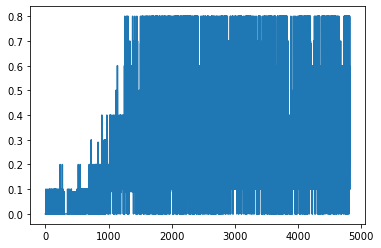

In [18]:
plt.plot(scores_list)

In [19]:
np.save('./score_list',scores_list)